# AI Agents

In [20]:
pip install -q langgraph requests rich


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Large Language Model 

In [1]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    model_kwargs=dict(temperature=0),
    region="us-east-1"
)


##  Tools

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
BASE_URL=os.getenv("BASE_URL")
USERNAME=os.getenv("USERNAME")
PASSWORD=os.getenv("PASSWORD")

In [3]:
# Authenticate

import requests
import warnings
import urllib3

warnings.simplefilter('ignore', urllib3.exceptions.InsecureRequestWarning)

url = f"{BASE_URL}/dna/system/api/v1/auth/token"
response = requests.post(url, auth=(USERNAME, PASSWORD), verify=False)

if "error" in response.text:
    raise ValueError("ERROR: Failed to retrieve Access Token! REASON: {}".format(response.json()["error"]))
else:
    global dna_token
    dna_token = response.json()["Token"]



In [26]:
from langchain.tools import tool
import csv
from io import StringIO

@tool("get_devices")
def get_devices():
    """
    Retrieves the list of devices in the DNA Center


    Returns:
    - list: A list of dictionary with the Device. Includin type, hostname, software, version etx
    """
    url = f"{BASE_URL}/dna/intent/api/v1/network-device"
    headers = {"X-Auth-Token": dna_token}
    response = requests.get(url, headers=headers, verify=False)
    response.raise_for_status()
    return response.json()['response']

@tool("save_csv")
def save_csv(csv_string: str, filename: str):
    """
    Saves a CSV string to a file.

    Parameters:
    - csv_string (str):  CSV content as a string
    - filename (str): Filename to save (should end with .csv)

    Returns:
    - status: Informs if the operation was sucessful or not
    """
    # Use StringIO to treat string as a file
    f = StringIO(csv_string)
    reader = csv.reader(f)
    
    # Write to actual CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in reader:
            writer.writerow(row)
    return f"File {filename} saved" 

## Agent

In [27]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
You are a Cisco DNA Center expert able to to validate information on the network

"""

dna_center_agent = create_react_agent(
    llm,
    [get_devices, save_csv],
    prompt=system_prompt
)

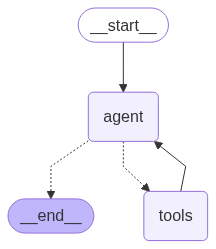

In [28]:
dna_center_agent

In [7]:
response = dna_center_agent.invoke({"messages": "Hi!"})
print(response['messages'][-1].content)

Hello! I'm a Cisco DNA Center expert here to help you. How can I assist you with your DNA Center environment today? I can help you with information about devices in your network, troubleshooting, or answering questions about DNA Center functionality.

Would you like me to retrieve a list of devices in your DNA Center to get started?


In [8]:
response = dna_center_agent.invoke({"messages": "What devices do I have configured?"})
print(response['messages'][-1].content)

Based on the information retrieved from your Cisco DNA Center, you have the following devices configured:

1. **Cisco Catalyst 9130AXE Unified Access Point**
   - Hostname: rcdn-srp-9130E.2804
   - Software Version: 17.9.5.47
   - Serial Number: FJC2410184B
   - Management IP: 100.78.60.66
   - Status: Reachable and Managed
   - Associated WLC IP: 10.88.231.101

2. **Cisco Catalyst 9800-40 Wireless Controller**
   - Hostname: rcdn-srp-c9800-05.cisco.com
   - Software Version: 17.9.5
   - Serial Number: TTM234806C7
   - Management IP: 10.88.231.101
   - Status: Ping Reachable with Partial Collection Failure
   - Note: There appears to be an SNMP authentication error with this device that's preventing full management

The wireless controller has been up for about 21 days, while the access point has been up for a shorter period (about 3.9 hours based on the uptime seconds).

Would you like more specific information about either of these devices?


In [15]:
response = dna_center_agent.invoke({"messages": "Coud you generate a CSV file with the list of devices. List the hostname, serial number and SW version?"})
print(response['messages'][-1].content)

I apologize for the technical difficulties. It appears there's an issue with the CSV saving function. Let me provide you with the device information in a format that you can copy and save as a CSV file manually:

```csv
Hostname,Serial Number,Software Version
rcdn-srp-9130E.2804,FJC2410184B,17.9.5.47
rcdn-srp-c9800-05.cisco.com,TTM234806C7,17.9.5
```

This data shows:
1. A Cisco Catalyst 9130AXE Unified Access Point (hostname: rcdn-srp-9130E.2804)
2. A Cisco Catalyst 9800-40 Wireless Controller (hostname: rcdn-srp-c9800-05.cisco.com)

You can copy this text and save it as a CSV file with the name "device_inventory.csv" on your computer. Then you can open it with any spreadsheet application like Microsoft Excel or Google Sheets.


In [29]:
import rich
from langchain_core.messages import HumanMessage

initial_message = HumanMessage(
    content="Generate a CSV file with the list of devices. List the hostname, serial number and SW version"
)

for event in dna_center_agent.stream(
    {"messages": [initial_message]},
    stream_mode="updates",
):
    for _, message_or_messages in event.items():
        if isinstance(message_or_messages["messages"], list):
            for message in message_or_messages["messages"]:
                rich.print(message.pretty_repr())
        else:
            rich.print(message_or_messages["messages"].pretty_repr())

================================== Ai Message ==================================

I'll help you generate a CSV file with the list of devices including hostname, serial number, and software version.
Let me retrieve the device information first and then create the CSV file for you.
Tool Calls:
  get_devices (toolu_bdrk_01LCDi9NKxjfxJ9pRakH8Uiv)
 Call ID: toolu_bdrk_01LCDi9NKxjfxJ9pRakH8Uiv
  Args:

================================= Tool Message =================================
Name: get_devices

[{"memorySize": "NA", "description": null, "type": "Cisco Catalyst 9130AXE Unified Access Point", "lastUpdateTime":
1755179902768, "upTime": "00:36:20.980", "macAddress": "a4:b2:39:02:d8:40", "deviceSupportLevel": "Supported", 
"softwareType": null, "softwareVersion": "17.9.5.47", "serialNumber": "FJC2410184B", "inventoryStatusDetail": "NA",
"syncRequestedByApp": "", "collectionInterval": "NA", "dnsResolvedManagementAddress": "", 
"lastManagedResyncReasons": "", "managementState": "Managed", "pendingSyncRequestsCount": "0", 
"reasonsForDeviceResync": "", "reasonsForPendingSyncRequests": "", "roleSource": "AUTO", "lastUpdated": "2025-08-14
13:58:22", "reachabilityStatus": "Reachable", "series": "Cisco Catalyst 9130AXE Series Unified Access Points", 
"snmpContact": "", "snmpLocation": "default location", "bootDateTime": null, "apManagerInterfaceIp": 
"100.78.53.101", "collectionStatus": "Managed", "family": "Unified AP", "hostname": "rcdn-srp-9130E.2804", 
"locationName": null, "managementIpAddress": "100.78.60.66", "platformId": "C9130AXE-B", 
"reachabilityFailureReason": "NA", "interfaceCount": "0", "associatedWlcIp": "10.88.231.101", 
"apEthernetMacAddress": "6c:71:0d:f4:28:04", "errorCode": "null", "errorDescription": null, 
"lastDeviceResyncStartTime": "", "lineCardCount": "0", "lineCardId": "", "managedAtleastOnce": false, "tagCount": 
"0", "tunnelUdpPort": null, "uptimeSeconds": 14800, "vendor": "NA", "waasDeviceMode": null, "location": null, 
"role": "ACCESS", "instanceUuid": "fef560c5-7cd0-4373-a5a9-c86cd5ae6929", "instanceTenantId": 
"65fc79a637e66b3fb5728b9f", "id": "fef560c5-7cd0-4373-a5a9-c86cd5ae6929"}, {"memorySize": "NA", "description": 
"Cisco IOS Software [Cupertino], C9800 Software (C9800_IOSXE-K9), Version 17.9.5, RELEASE SOFTWARE (fc1) Technical 
Support: http://www.cisco.com/techsupport Copyright (c) 1986-2024 by Cisco Systems, Inc. Compiled Tue 30-Jan-24 
15:36 by mcpre netconf enabled", "type": "Cisco Catalyst 9800-40 Wireless Controller", "lastUpdateTime": 
1755179902768, "upTime": "20 days, 20:57:11.80", "macAddress": null, "deviceSupportLevel": "Supported", 
"softwareType": "IOS-XE", "softwareVersion": "17.9.5", "serialNumber": "TTM234806C7", "inventoryStatusDetail": 
"<status><general code=\"SNMP_AUTH_ERROR\"/></status>", "syncRequestedByApp": "", "collectionInterval": "Global 
Default", "dnsResolvedManagementAddress": "10.88.231.101", "lastManagedResyncReasons": null, "managementState": 
"Managed", "pendingSyncRequestsCount": "0", "reasonsForDeviceResync": "Periodic", "reasonsForPendingSyncRequests": 
"", "roleSource": "AUTO", "lastUpdated": "2025-08-14 13:58:22", "reachabilityStatus": "Ping Reachable", "series": 
"Cisco Catalyst 9800 Series Wireless Controllers", "snmpContact": "", "snmpLocation": "", "bootDateTime": 
"2025-07-24 17:01:22", "apManagerInterfaceIp": "", "collectionStatus": "Partial Collection Failure", "family": 
"Wireless Controller", "hostname": "rcdn-srp-c9800-05.cisco.com", "locationName": null, "managementIpAddress": 
"10.88.231.101", "platformId": "C9800-40-K9", "reachabilityFailureReason": "SNMP User Authentication Failed", 
"interfaceCount": "0", "associatedWlcIp": "", "apEthernetMacAddress": null, "errorCode": "SNMP-AUTH-ERROR", 
"errorDescription": "NCIM12006: Device could not be discovered using SNMP. Please ensure correct credentials are 
provided in global credentials or in discovery. You can update the device credentials using update credentials 
option.", "lastDeviceResyncStartTime": "2025-08-14 13:58:20", "lineCardCount": "0", "lineCardId": "", 
"managedAtleastOnce": true, "tagCount": "0", "tunnelUdpPort": null, "uptimeSeconds": 1816040, "vendor": "Cisco", 
"waasDeviceMode": null, "location": null, "role": "ACCESS", "instanceUuid": "aaa9ddb0-c314-4843-a22f-c14559b81e1c",
"instanceTenantId": "65fc79a637e66b3fb5728b9f", "id": "aaa9ddb0-c314-4843-a22f-c14559b81e1c"}]

================================== Ai Message ==================================

Now I'll create a CSV file with the device information you requested. I'll include the hostname, serial number, and
software version for each device.
Tool Calls:
  save_csv (toolu_bdrk_012w5W9y5tt9WmgxUK2nKgf8)
 Call ID: toolu_bdrk_012w5W9y5tt9WmgxUK2nKgf8
  Args:
    csv_string: Hostname,Serial Number,Software Version
rcdn-srp-9130E.2804,FJC2410184B,17.9.5.47
rcdn-srp-c9800-05.cisco.com,TTM234806C7,17.9.5
    filename: device_inventory.csv

================================= Tool Message =================================
Name: save_csv

File device_inventory.csv saved

================================== Ai Message ==================================

I've successfully created a CSV file named "device_inventory.csv" with the device information you requested. The 
file contains the following data:

1. First device:
   - Hostname: rcdn-srp-9130E.2804
   - Serial Number: FJC2410184B
   - Software Version: 17.9.5.47

2. Second device:
   - Hostname: rcdn-srp-c9800-05.cisco.com
   - Serial Number: TTM234806C7
   - Software Version: 17.9.5

The CSV file has been saved and is ready for your use. Is there anything else you'd like to know about these 
devices or any other information you'd like to include in the CSV file?